# Computer Vision Project - Detecting Basic Shapes in Images 

In [1]:
import cv2
import numpy as np
import os
import random

In [18]:
# functions to generate a dataset of images with random shapes (circle, square, triangle) 
# that have random positions, sizes, rotation (unimplemented), and color, then saves them in YOLO format.

# helper function used to create a shape on the image
# parameters:
    # img: the image to draw on
    # shape: the type of shape to draw as string (e.g., circle, square, triangle)
    # img_size: the size of the image (used to determine the size of the shape)
# returns: the bounding box of the shape in the format [x1, y1, x2, y2]
def create_shape(img, shape, img_size):
    h, w, _ = img.shape # get the height, width, and number of channels of the image
    size = random.randint(int(img_size * 0.1), int(img_size * 0.9)) # get random size between 10% and 90% of the image size for the shape
    x, y = random.randint(0, w - size), random.randint(0, h - size) # get random x and y coordinates for the shape within the image bounds
    color = tuple(random.randint(0, 255) for _ in range(3)) # get random color for the image in BGR format
    
    # draw the shape on the image based on the type of shape
    # and return the (corner positions of the) bounding box of the shape
    if shape == "circle":
        center = (x + size // 2, y + size // 2)
        cv2.circle(img, center, size // 2, color, -1)
        bbox = [x, y, x + size, y + size] 
    
    elif shape == "square":
        cv2.rectangle(img, (x, y), (x + size, y + size), color, -1)
        bbox = [x, y, x + size, y + size]
    
    elif shape == "triangle":
        pts = np.array([[x, y + size], [x + size, y + size], [x + size // 2, y]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], color)
        bbox = [x, y, x + size, y + size]
    
    return bbox

# helper function used to create a gradient background with random colors
# parameters:
    # img_size: the size of the image (used to determine the size of the background)
    # gradient: bool to determine whether to create a gradient background or a solid color background
# returns: the background image as a numpy array
def generate_background(img_size, gradient=True):
    if gradient:    # generate a gradient background
        # generate two random colors for the gradient (gradient starts from one color and ends at the other color)
        start_color = np.array([random.randint(0, 255) for _ in range(3)])
        end_color = np.array([random.randint(0, 255) for _ in range(3)])
        #initialize the background image with zeros (black)
        bg = np.zeros((img_size, img_size, 3))
        # loop through image size (i.e., pixels) and assign the color to each pixel based on the gradient
        for i in range(img_size):
            color = start_color + (end_color - start_color) * (i / img_size)
            bg[i, :] = color
    else:   # generate a solid color background
        bg_color = tuple(random.randint(0, 255) for _ in range(3))
        bg = np.full((img_size, img_size, 3), bg_color, dtype=np.uint8)
    return bg

# used to generate the dataset of shape images
# parameters:
    # output_dir: the directory to save the generated images and labels
    # num_images: the number of images to generate
    # img_size: the size of the image (width and height)
    # min_shapes: minimum number of shapes in each image
    # max_shapes: maximum number of shapes in each image
    # gradient_bg: whether to use a gradient background or a solid color background
# returns: None (the function saves the images and labels in the specified directory)
def generate_dataset(output_dir, num_images=1000, img_size=256, min_shapes=2, max_shapes=5, gradient_bg=True):
    # Create output directories for images and labels
    os.makedirs(output_dir, exist_ok=True)  # create the output directory if it doesn't exist
    labels_dir = os.path.join(output_dir, "labels/train") #labels/train, labels/val, labels/test
    images_dir = os.path.join(output_dir, "images/train") #images/train, images/val, images/test
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir, exist_ok=True)
    
    shape_classes = {"circle": 0, "square": 1, "triangle": 2} # shape dict with shape names as keys and class indices as values
    
    # loop through the number of images desired and create an image for each one
    for i in range(num_images):
        img = generate_background(img_size, gradient=gradient_bg)
        num_shapes = random.randint(min_shapes, max_shapes)  # Number of shapes per image
        
        annotations = []
        # Loop through the number of shapes desired for the image and create a shape in the image for each one
        for _ in range(num_shapes):
            shape = random.choice(list(shape_classes.keys()))   # pick a random shape from the keys for the dict of shapes
            bbox = create_shape(img, shape, img_size)           # create the shape in the image and get its bounding box
            
            # Convert to YOLO format
            x_center = (bbox[0] + bbox[2]) / 2 / img_size
            y_center = (bbox[1] + bbox[3]) / 2 / img_size
            width = (bbox[2] - bbox[0]) / img_size
            height = (bbox[3] - bbox[1]) / img_size
            # append class index of the shape using 'shape' key from the dict of shapes and rest of the calculated values
            annotations.append(f"{shape_classes[shape]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        
        # Save image
        img_path = os.path.join(images_dir, f"{i}.jpg")
        cv2.imwrite(img_path, img)
        
        # Save annotation file
        label_path = os.path.join(labels_dir, f"{i}.txt")
        with open(label_path, "w") as f:
            f.write("\n".join(annotations))
    
    print(f"Dataset generated: {num_images} images in {output_dir}")

In [19]:
# generate dataset
generate_dataset("shape_dataset", num_images=400, img_size=256, min_shapes=1, max_shapes=1, gradient_bg=True)

Dataset generated: 400 images in shape_dataset


In [ ]:
'''
yaml file for the dataset:

path: C:/Users/endle/.Uni/Computer_Vision/project_shapes/CV-Project-ShapeDetection/shape_dataset
train: images/train
val: images/val
test: images/test
nc: 3
names: ['circle', 'square', 'triangle']

'''

In [34]:
from ultralytics import YOLO
import yaml
from ultralytics.utils.plotting import Annotator
import matplotlib.pyplot as plt
%matplotlib inline
# import xml.etree.ElementTree as ET
# from sklearn.model_selection import train_test_split
# import shutil

In [21]:
# get a pretrained YOLOv8 model
model = YOLO("yolov8n.pt") # load the YOLOv8 model

100%|██████████| 6.25M/6.25M [00:01<00:00, 6.13MB/s]


In [52]:
yaml_path = "./shape_dataset/shapes.yaml" # path to the yaml file for the dataset

# train model on dataset using yaml file
train_results = model.train(
    data = yaml_path,
    epochs = 20,
    # imgsz = 256,
    batch = 16,
    name = "yolo_shapes",
    project = "./runs/detect",)

# evaluate model on dataset using yaml file
results = model.val(data = yaml_path)

New https://pypi.org/project/ultralytics/8.3.101 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=./shape_dataset/shapes.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=8, project=./runs/detect, name=yolo_shapes3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

train: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset\labels\train.cache... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<?, ?it/s]
val: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset\labels\val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolo_shapes3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to runs\detect\yolo_shapes3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.576G     0.4339     0.6072     0.9876         29        256: 100%|██████████| 25/25 [00:05<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

                   all        100        100      0.995      0.991      0.994      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.576G     0.4555     0.6152     0.9973         29        256: 100%|██████████| 25/25 [00:01<00:00, 17.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.98it/s]

                   all        100        100      0.996      0.994      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.576G     0.4652     0.6153     0.9877         29        256: 100%|██████████| 25/25 [00:01<00:00, 17.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.46it/s]

                   all        100        100      0.988      0.992      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.576G     0.4655     0.6071     0.9983         32        256: 100%|██████████| 25/25 [00:01<00:00, 18.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.23it/s]

                   all        100        100      0.952       0.98      0.989      0.956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.576G     0.4678     0.6107     0.9888         36        256: 100%|██████████| 25/25 [00:01<00:00, 19.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.42it/s]

                   all        100        100      0.995      0.992      0.995       0.95



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.576G     0.4537     0.5799     0.9778         31        256: 100%|██████████| 25/25 [00:01<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

                   all        100        100      0.992      0.989      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.576G     0.4346      0.579     0.9784         25        256: 100%|██████████| 25/25 [00:01<00:00, 19.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

                   all        100        100      0.997      0.995      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.576G     0.4346     0.5561     0.9842         36        256: 100%|██████████| 25/25 [00:01<00:00, 18.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]

                   all        100        100      0.996      0.992      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.576G      0.436     0.5709     0.9804         41        256: 100%|██████████| 25/25 [00:01<00:00, 19.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]

                   all        100        100      0.978      0.995      0.994      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.576G       0.41     0.5307     0.9631         42        256: 100%|██████████| 25/25 [00:01<00:00, 19.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

                   all        100        100      0.997      0.993      0.995      0.976


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.576G     0.3184      0.535     0.8767         15        256: 100%|██████████| 25/25 [00:01<00:00, 16.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.79it/s]

                   all        100        100       0.96          1      0.992      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.576G     0.2858     0.4618     0.8395         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

                   all        100        100      0.994      0.999      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.576G     0.2697     0.4375     0.8482         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]

                   all        100        100      0.995          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.576G     0.2703     0.3977     0.8501         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]

                   all        100        100      0.997          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.576G     0.2505     0.3802     0.8276         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]

                   all        100        100      0.998          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.576G     0.2472     0.3729      0.846         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]

                   all        100        100      0.998          1      0.995      0.982



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.576G     0.2375     0.3494      0.847         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]

                   all        100        100      0.998          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.576G     0.2255     0.3424     0.8242         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.55it/s]

                   all        100        100      0.998          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.576G     0.2322     0.3363     0.8257         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.26it/s]

                   all        100        100      0.998          1      0.995      0.985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.576G     0.2266     0.3359     0.8263         16        256: 100%|██████████| 25/25 [00:01<00:00, 19.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 11.48it/s]

                   all        100        100      0.998          1      0.995      0.986



20 epochs completed in 0.019 hours.
Optimizer stripped from runs\detect\yolo_shapes3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolo_shapes3\weights\best.pt, 6.2MB

Validating runs\detect\yolo_shapes3\weights\best.pt...
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.61it/s]


                   all        100        100      0.998          1      0.995      0.986
                circle         32         32      0.997          1      0.995      0.989
                square         27         27      0.997          1      0.995      0.991
              triangle         41         41      0.999          1      0.995      0.977
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\yolo_shapes3
Ultralytics 8.3.88  Python-3.12.7 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12281MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\shape_dataset\labels\val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]


                   all        100        100      0.998          1      0.995      0.986
                circle         32         32      0.997          1      0.995      0.989
                square         27         27      0.998          1      0.995      0.991
              triangle         41         41      0.999          1      0.995      0.977
Speed: 0.4ms preprocess, 2.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\yolo_shapes32



image 1/1 c:\Users\endle\.Uni\Computer_Vision\project_shapes\CV-Project-ShapeDetection\test_images\image1.png: 192x256 2 triangles, 8.8ms
Speed: 0.8ms preprocess, 8.8ms inference, 2.8ms postprocess per image at shape (1, 3, 192, 256)


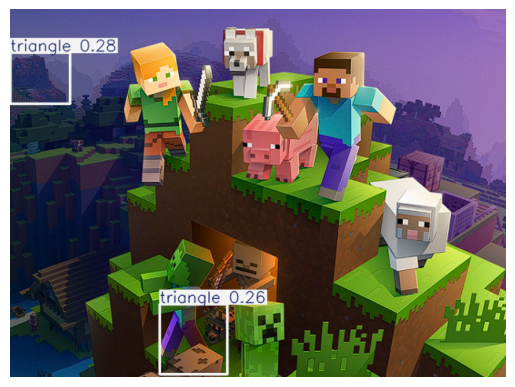

In [60]:
# test model on a test image
image_path = "test_images/image1.png" # path to the test image

# Load the trained model
trained_model = YOLO("./runs/detect/yolo_shapes3/weights/best.pt")  

# Run inference
# results = trained_model.predict(source=image_path, save=True, project = "./runs/detect")  # Save output image with detections
results = trained_model.predict(source = image_path, save = False)

# Access the first result and render it
annotated_image = results[0].plot()  # Returns image with bounding boxes (as a NumPy array)

# Display it with matplotlib
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()